## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [145]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [147]:
data['date'] = pd.to_datetime(data['date'])
print('Начало тестирования в группе А:', 
      data[data['group'] == 'A']['date'].min())
print('Окончание тестирования в группе А:', 
      data[data['group'] == 'A']['date'].max())
print('Начало тестирования в группе B:', 
      data[data['group'] == 'B']['date'].min())
print('Окончание тестирования в группе B:',
      data[data['group'] == 'B']['date'].max())

Начало тестирования в группе А: 2021-01-02 00:00:00
Окончание тестирования в группе А: 2021-01-24 00:00:00
Начало тестирования в группе B: 2021-01-02 00:00:00
Окончание тестирования в группе B: 2021-01-24 00:00:00


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [148]:
print('Кол-во посещений сайта в группе А:', 
     data[data['group'] == 'A'].shape[0])
print('Кол-во посещений сайта в группе В:', 
     data[data['group'] == 'B'].shape[0])
print('Кол-во покупок в группе А:', 
      data[data['group'] == 'A']['purchase'].sum())
print('Кол-во покупок в группе B:', 
      data[data['group'] == 'B']['purchase'].sum())
print('Сумма всех покупок в группе А (млн. руб.):', 
      data[data['group'] == 'A']['price'].sum() / 10**6)
print('Сумма всех покупок в группе В (млн. руб.):', 
      data[data['group'] == 'B']['price'].sum() / 10**6)

Кол-во посещений сайта в группе А: 147202
Кол-во посещений сайта в группе В: 147276
Кол-во покупок в группе А: 17723
Кол-во покупок в группе B: 17514
Сумма всех покупок в группе А (млн. руб.): 1436.26
Сумма всех покупок в группе В (млн. руб.): 1554.1


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [149]:
users_a = set(data[data['group'] == 'A']['user_id'].tolist())
users_b = set(data[data['group'] == 'B']['user_id'].tolist())
user_intersection = users_a.intersection(users_b)
print('Количество пользователей попавших в обе группы:', 
      len(user_intersection))

Количество пользователей попавших в обе группы: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [150]:
updated_data = data[data['user_id'].apply(
    lambda x: x not in user_intersection)]


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

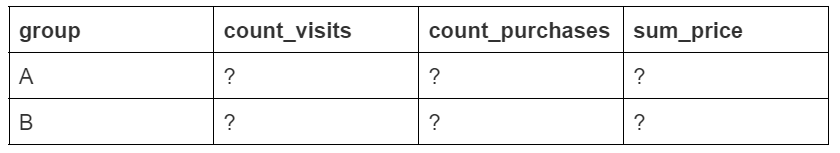
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [151]:
grouped_data = updated_data.groupby('group').agg(
    {'user_id' : 'count', 
     'purchase' : 'sum', 
     'price' : 'sum'}
    )
grouped_data = grouped_data.rename(
    columns={'user_id' : 'count_visits', 
             'purchase' : 'count_purchases', 
             'price' : 'sum_price'}
    )
grouped_data

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Количество пользователей в выборке практически одинаковое. Выборки сбалансированы.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [152]:
grouped_data['conversion'] = grouped_data['count_purchases'] *100 \
    / grouped_data['count_visits']
grouped_data['mean_check'] = grouped_data['sum_price'] \
    / grouped_data['count_purchases']
grouped_data

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Коверсия в варианте А выше чем в варианте В, но средний чек при варианте А меньше чем средний чек варианта В.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [153]:
group_price_data = updated_data.groupby(['group', 'price']).agg(
    {'purchase' : 'sum'}) 
display(group_price_data)


purchase
group price           
A     0              0
      10000       5182
      60000       5271
      100000      1832
      150000      3478
      200000      1724
B     0              0
      10000       5201
      60000       1730
      100000      5227
      150000      3438
      200000      1694

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

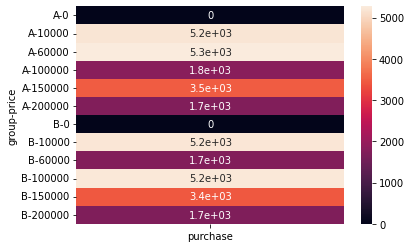

In [154]:
fig = sns.heatmap(group_price_data, annot=True)

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Покупательская способность группы А выше в категории туров в Турцию (60000 руб.), в то время как в группе существенно большим спросом пользовались туры в Тайланд (100000 руб.). В остальных категориях спрос примерно одинаковый.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [155]:
daily_data = updated_data.groupby(['group', 'date']).agg({
    'user_id' : 'count', 'purchase' : 'sum', 'price' : 'sum'}).reset_index()
daily_data = daily_data.rename(columns={'user_id' : 'count_visits',
                                        'purchase' : 'count_purchases',
                                        'price' : 'sum_price'})
daily_data['conversion'] = daily_data['count_purchases'] * 100 \
    / daily_data['count_visits']
daily_data['mean_check'] = daily_data['sum_price'] \
    / daily_data['count_purchases']
print('Конверсия 3 января 2021 года в группе А:', daily_data[
    (daily_data['date'] == '2021-01-03') & (daily_data['group'] == 'A')
    ]['conversion'])
print('Конверсия 3 января 2021 года в группе B:', daily_data[
    (daily_data['date'] == '2021-01-03') & (daily_data['group'] == 'B')
    ]['conversion'])




Конверсия 3 января 2021 года в группе А: 1    11.340206
Name: conversion, dtype: float64
Конверсия 3 января 2021 года в группе B: 24    11.391449
Name: conversion, dtype: float64


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [156]:
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']
daily_data_a['cum_visits'] = daily_data_a['count_visits'].cumsum()
daily_data_a['cum_purchases'] = daily_data_a['count_purchases'].cumsum()
daily_data_a['cum_price'] = daily_data_a['sum_price'].cumsum()
daily_data_b['cum_visits'] = daily_data_b['count_visits'].cumsum()
daily_data_b['cum_purchases'] = daily_data_b['count_purchases'].cumsum()
daily_data_b['cum_price'] = daily_data_b['sum_price'].cumsum()

daily_data_a['cum_conversion'] = daily_data_a['cum_purchases'] * 100 \
    / dayly_data_a['cum_visits']
daily_data_a['cum_mean_check'] = daily_data_a['cum_price'] \
    / daily_data_a['cum_purchases']
daily_data_b['cum_conversion'] = daily_data_b['cum_purchases'] * 100 \
    / dayly_data_b['cum_visits']
daily_data_b['cum_mean_check'] = daily_data_b['cum_price'] \
    / daily_data_b['cum_purchases']

print('Кумулятивная конверсия в группе B на 20 января:', \
    daily_data_b[daily_data_b['date'] == '2021-01-20']['cum_conversion'])
print('Кумулятивный средний чек в группе А на 12 января:', \
    daily_data_a[daily_data_a['date'] == '2021-01-12']['cum_mean_check'])
daily_data = daily_data_a.append(daily_data_b)
daily_data

Кумулятивная конверсия в группе B на 20 января: 41    11.895911
Name: cum_conversion, dtype: float64
Кумулятивный средний чек в группе А на 12 января: 10    81491.827275
Name: cum_mean_check, dtype: float64


C:\Users\Talic\AppData\Local\Temp\ipykernel_7932\1741128483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a['cum_visits'] = daily_data_a['count_visits'].cumsum()
C:\Users\Talic\AppData\Local\Temp\ipykernel_7932\1741128483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a['cum_purchases'] = daily_data_a['count_purchases'].cumsum()
C:\Users\Talic\AppData\Local\Temp\ipykernel_7932\1741128483.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,group,date,count_visits,count_purchases,sum_price,conversion,mean_check,cum_visits,cum_purchases,cum_price,cum_conversion,cum_mean_check
0,A,2021-01-02,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,A,2021-01-03,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
2,A,2021-01-04,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530
3,A,2021-01-05,6433,790,64550000,12.280429,81708.860759,22449,2696,220210000,12.009444,81680.267062
4,A,2021-01-06,6606,764,63410000,11.565244,82997.382199,29055,3460,283620000,11.908449,81971.098266
5,A,2021-01-07,6579,795,67290000,12.083903,84641.509434,35634,4255,350910000,11.940843,82470.035253
6,A,2021-01-08,6687,798,65380000,11.933603,81929.824561,42321,5053,416290000,11.939699,82384.721947
7,A,2021-01-09,6633,794,65610000,11.970451,82632.241814,48954,5847,481900000,11.943866,82418.334188
8,A,2021-01-10,6659,759,58950000,11.398108,77667.984190,55613,6606,540850000,11.878518,81872.540115
9,A,2021-01-11,6699,797,58760000,11.897298,73726.474279,62312,7403,599610000,11.880537,80995.542348


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

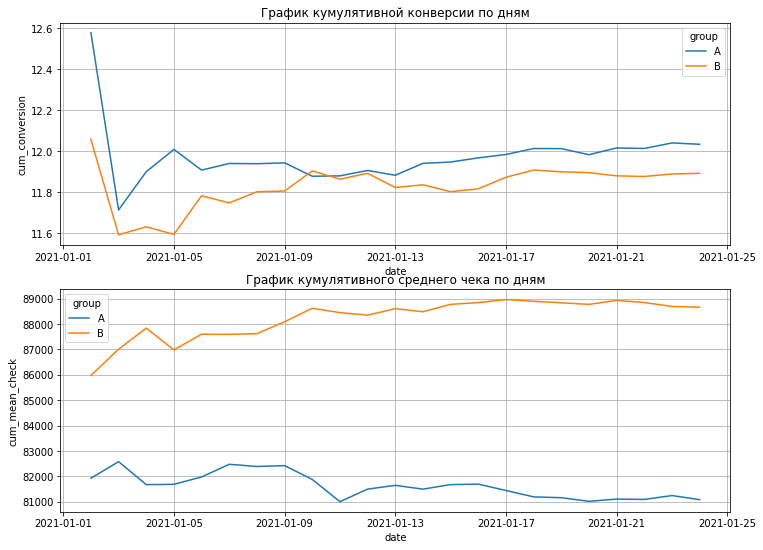

In [157]:
# создаём фигуру размером 8x4
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))
sns.lineplot(
    x='date', 
    y='cum_conversion', 
    data=daily_data, 
    hue='group', 
    ax=axes[0]
    )
# задаём подпись к графику
axes[0].set_title('График кумулятивной конверсии по дням')
axes[0].grid(True)
sns.lineplot(
    x='date', 
    y='cum_mean_check', 
    data=daily_data, 
    hue='group', 
    ax=axes[1]
    )
axes[1].set_title('График кумулятивного среднего чека по дням')
axes[1].grid(True)

Данные метрик стабилизировались во времени. А/В тест можно считать заверщенным.  Конверсия в группе А выше чем в группе В, в то время как средний чек выше в группе В.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [158]:
total_data = updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']).reset_index() 
total_data['conversion'] = total_data['sum'] / total_data['count']

alpha = 0.05
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе B'
_, p_value = proportions_ztest(
    count=total_data['sum'],
    nobs=total_data['count'],
    alternative='larger')

if p_value > alpha:
    print(p_value,'>', alpha, '.', H0)
else: print(p_value,'<', alpha, '.', H1)
total_data

0.11970374924914917 > 0.05 . Конверсии в группах А и B равны


,group,sum,count,conversion
0,A,17487,145307,0.120345
1,B,17290,145381,0.118929


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Конверсии в группах А и В статистически равны.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [159]:
from confidence_interval import proportions_conf_interval
from confidence_interval import diff_proportions_conf_interval

print('Доверительный интревал конверсии группы А:',
      proportions_conf_interval(
    total_data['count'].iloc[0],
    total_data['conversion'].iloc[0]))
print('Доверительный интревал конверсии группы B:',
      proportions_conf_interval(
    total_data['count'].iloc[1],
    total_data['conversion'].iloc[1])
      )

n = total_data['count']
xp = total_data['conversion']
#display(n, xp)
print('Доверительный интревал разницы конверсий групп А и В:',
      diff_proportions_conf_interval(n, xp)
      )


Доверительный интревал конверсии группы А: (11.87, 12.2)
Доверительный интревал конверсии группы B: (11.73, 12.06)
Доверительный интревал разницы конверсий групп А и В: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Доверительные интервалы для групп А и В перекрываются. Доверительный интервал статистической разницы конверсий групп А и В лежит по обе стороны от нуля, что говорит нам о том что статистической разницы между конверсиями групп нет.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [160]:
H0 = 'Данные по дневному среднему чеку распределены нормально'
Ha = 'Данные по дневному среднему чеку не распределены нормально'

_, p_a = shapiro(daily_data_a['mean_check'])
_, p_b = shapiro(daily_data_b['mean_check'])
alpha = 0.05

if p_a > alpha:
	print('В группе А: ', H0)
else:
	print('В группе А: ', Ha)
 
if p_b > alpha:
	print('В группе B: ', H0)
else:
	print('В группе B: ', Ha)

В группе А:  Данные по дневному среднему чеку распределены нормально
В группе B:  Данные по дневному среднему чеку распределены нормально


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [161]:
H0 = 'Нет значимой разницы между ежедневными средними чеками в группах'
Ha = 'Есть значимая разница между ежедневными средними чеками в группах'
alpha = 0.05

_, p_val = ttest_ind(daily_data_a['mean_check'], daily_data_b['mean_check'])
if p_val > alpha:
	print(H0)
else:
	print(Ha)


Есть значимая разница между ежедневными средними чеками в группах


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Есть значимая статисчтическая разница между ежедневными средними чеками в группах А и В.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [162]:
from confidence_interval import t_distribution

print('Доверительный интервал среднечего чека в группе A:',
      t_distribution(
    daily_data_a['mean_check'].count(),
    daily_data_a['mean_check'].mean(),
    daily_data_a['mean_check'].std(),
    digits=0)
      )
print('Доверительный интервал среднечего чека в группе В:',
      t_distribution(
    daily_data_b['mean_check'].count(),
    daily_data_b['mean_check'].mean(),
    daily_data_b['mean_check'].std(),
    digits=0)
      )

Доверительный интервал среднечего чека в группе A: (79630.0, 82308.0)
Доверительный интервал среднечего чека в группе В: (87626.0, 89526.0)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Пересечений доверительных интервалов средних чеков в группах А и В нет, что говорит об их статистически значимой разнице.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Вывод: разница в конверсии различных вариантов дизайна статистически незначима. Средний чек для альтернативного дизайна стстаистически выше среднего чека базового дизайна.
Дизайн В эффективнее в контексте среднего чека.